In [1]:
%matplotlib notebook
import xemc3
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, ticker
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as colors
import xarray as xr
import numpy as np
import ipywidgets as widgets
import mpl_interactions.ipyplot as iplt
from pathlib import Path
from brokenaxes import brokenaxes

philip_folder =  "/u/phg/adas/atomdatpy/NetCDFs-new"
experiment_folder = "N03.00_P05.00_D05_R02.00-C"
plotfolder = "./plots"

dsdir = Path("../atomdatpy/NetCDFs-new/")
paths = (sorted(dsdir.glob("N03.00_P05.00_D02_R0*"), reverse=True))[:]
cpaths = paths[:5]
diff_paths = [paths[-3], paths[-1], paths[-2]]
all_paths = [*cpaths[:-1], *diff_paths]
interesting_paths = [cpaths[0], cpaths[2], cpaths[4], *diff_paths]
# ds = xr.open_dataset(path)

In [2]:
def crossec_pcolorgrid(ds, phi):
    # (A+1)*(B+1) = AB + A + B +1
    outR = np.empty((len(ds["r"])+1, len(ds["theta"])+1))
    outZ = outR.copy()
    
    outR[:-1,:-1] = ds["R_bounds"][ :, :,phi,0,0,0]  # AB
    outR[:-1, -1] = ds["R_bounds"][ :,-1,phi,0,1,0]  # A
    outR[ -1,:-1] = ds["R_bounds"][-1, :,phi,1,0,0]  # B
    outR[ -1, -1] = ds["R_bounds"][-1,-1,phi,1,1,0]  # 1
    
    outZ[:-1,:-1] = ds["z_bounds"][ :, :,phi,0,0,0]  # AB
    outZ[:-1, -1] = ds["z_bounds"][ :,-1,phi,0,1,0]  # A
    outZ[ -1,:-1] = ds["z_bounds"][-1, :,phi,1,0,0]  # B
    outZ[ -1, -1] = ds["z_bounds"][-1,-1,phi,1,1,0]  # 1
    
    return outR, outZ

In [3]:
def get_color(f, d):
    d2 = np.sqrt((10*d-2)/8)
    r = cm.magma( (f-0.4)*1.8 )
    s = tuple((1-d2)*rr + d2*0.6 for rr in r)
    #print(f,d,d2,r,s)
    return s

In [4]:
pl1_arr_mean, pl1_arr_std = [], []
for cpath in all_paths:
    ds = xr.open_dataset(cpath)
    dsez = ds.Ez.sum(dim="Ionization", skipna=False)
    pl1_arr_mean.append(dsez.mean(dim=("r", "theta")))
    pl1_arr_std.append(dsez.std(dim=("r", "theta")))

In [5]:
ds = xr.open_dataset(all_paths[5])
dsez = ds.Ez.sum(dim="Ionization", skipna=False)
min_target_toroidal = np.isnan(dsez).any(dim="theta")[22:].argmax(dim="r") + 22


<IPython.core.display.Javascript object>


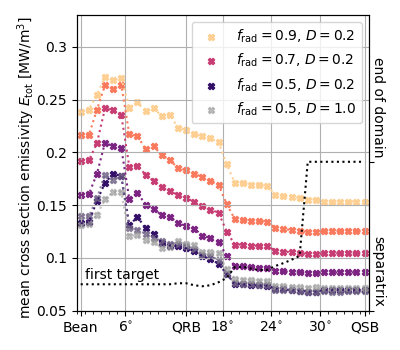

In [274]:
plt.close("all")
fig, ax = plt.subplots(figsize=(4,3.5))
MW_fac = 1e-6

for cpath, dsez, dsezstd in zip(all_paths, pl1_arr_mean, pl1_arr_std):
    frad = float(cpath.stem[20:24])/float(cpath.stem[9:13])
    diffval = float(2 if cpath.stem[-1]=="C" else cpath.stem[-2:])/10
    label="$f_{\mathrm{rad}} =$" + str(frad) + ", $D=$" + str(diffval)
    phi_vals = ds.phi_bounds.data.mean(axis=1) * 180/np.pi
    ax.scatter(phi_vals, MW_fac*dsez, color=get_color(frad, diffval),
           label=(None if (0.55<frad<0.65 or 0.75<frad<0.85 or diffval==0.5) else label), marker="X", s=20)
    ax.plot(phi_vals, MW_fac*dsez, c=get_color(frad, diffval), ls=":")
    

#ax.set_yscale("log"); 
ax.legend(loc=1)
ax.set_xlim((0,36))
ax.set_xticks(range(37), minor=True)
ax.set_xticks([0.5, 6, 13.5, 18, 24, 30, 35.5], minor=False)
ax.set_xticklabels(["Bean", "6$^{\circ}$", "QRB", "18$^{\circ}$", "24$^{\circ}$",
                    "30$^{\circ}$", "QSB"])
ax.set_yticks(MW_fac*np.array([0, 0.5e5, 1e5, 1.5e5, 2e5, 2.5e5, 3e5]))
ax.set_yticklabels(["0.0", "0.05", "0.1", "0.15", "0.2", "0.25", "0.3"])
ax.grid()
ax.set_ylabel("mean cross section emissivity $E_{\mathrm{tot}}$ [MW/m$^3$]   ", verticalalignment="baseline")
ax.set_ylim((MW_fac*6e4, MW_fac*3.3e5))

fig.tight_layout()
ax.set_ylim((MW_fac*0.5e5, MW_fac*3.3e5))
ax2 = ax.twinx()
outer_rad_map = ds.R_bounds[:,len(ds.theta)//2,0,:,0,0].mean(dim="delta_r")
# 5.8807, 6.2072, 6.4102078
ax2.plot(phi_vals, outer_rad_map[min_target_toroidal], ls=":", c="k")
ax2.set_ylim((6.2072, 0.2+6.4102078))
ax2.set_yticks([6.2072, 6.4102078])
ax2.set_yticklabels([None, None], rotation=270, ha="left", va="bottom")
ax2.text(36.3, 6.2172, "separatrix", rotation=270)
ax2.text(36.3, 6.4202078, "end of domain", rotation=270)
ax2.text(1, 6.25, "first target", ha="left")
fig.tight_layout()
fig.tight_layout()
fig.savefig(f"{plotfolder}/emissivity-mean-toroidal-change.pdf")
fig.savefig(f"{plotfolder}/emissivity-mean-toroidal-change.png", dpi=200)


# std is huge!

<IPython.core.display.Javascript object>


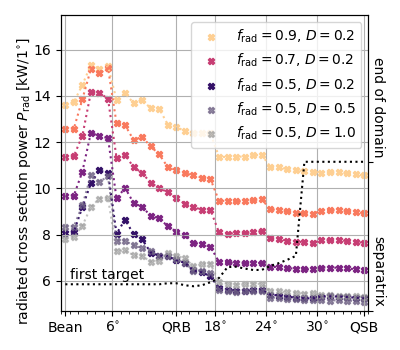

../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R04.50-C.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R04.00-C.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R03.50-C.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R03.00-C.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C-D05.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C-D10.nc


In [273]:
plt.close("all")
fig, ax = plt.subplots(figsize=(4, 3.5))
kW_fac = 1e-3
gv = np.load("./data/volumes.npy")

for cpath in all_paths:
    print(cpath)
    ds = xr.open_dataset(cpath)
    dsez = ds.Ez.sum(dim="Ionization", skipna=False).data # dsez.mean(dim=("r", "theta"))
    P = np.nan_to_num(dsez) * gv # W
    torP = P.sum(axis=(0,1))
    
    frad = float(cpath.stem[20:24])/float(cpath.stem[9:13])
    diffval = float(2 if cpath.stem[-1]=="C" else cpath.stem[-2:])/10
    
    phi_vals = ds.phi_bounds.data.mean(axis=1) * 180/np.pi
    label = "$f_{\mathrm{rad}} =$" + str(frad) + ", $D=$" + str(diffval)
    ax.scatter(phi_vals, kW_fac*torP, color=get_color(frad, diffval),
           label=(None if (0.55<frad<0.65 or 0.75<frad<0.85) else label), marker="X", s=20)
    ax.plot(phi_vals, kW_fac*torP, c=get_color(frad, diffval), ls=":")

#ax.set_yscale("log"); 
ax.legend(loc=1)
ax.set_xlim((0,36))
ax.set_xticks(range(37), minor=True)
ax.set_xticks([0.5, 6, 13.5, 18, 24, 30, 35.5], minor=False)
ax.set_xticklabels(["Bean", "6$^{\circ}$", "QRB", "18$^{\circ}$", "24$^{\circ}$",
                    "30$^{\circ}$", "QSB"])
ax.set_yticks([6, 8, 10, 12, 14, 16, 18])
#ax.set_yticklabels(["0.0", "0.05", "0.1", "0.15", "0.2", "0.25", "0.3"])
ax.grid()
ax.set_ylabel("radiated cross section power $P_{\mathrm{rad}}$ [kW/$1^{\circ}$]         ",
              verticalalignment="baseline")
ax.set_ylim((4.7, 17.5))

fig.tight_layout()
#ax.set_ylim((MW_fac*0.5e5, MW_fac*3.3e5))
ax2 = ax.twinx()
outer_rad_map = ds.R_bounds[:,len(ds.theta)//2,0,:,0,0].mean(dim="delta_r")
# 5.8807, 6.2072, 6.4102078
ax2.plot(phi_vals, outer_rad_map[min_target_toroidal], ls=":", c="k")
ax2.set_ylim((6.2072, 0.2+6.4102078))
ax2.set_yticks([6.2072, 6.4102078])
ax2.set_yticklabels([None, None], rotation=270, ha="left", va="bottom")
ax2.text(36.3, 6.2172, "separatrix", rotation=270)
ax2.text(36.3, 6.4202078, "end of domain", rotation=270)
ax2.text(1, 6.25, "first target", ha="left")
fig.tight_layout()
fig.tight_layout()
fig.savefig(f"{plotfolder}/power-sum-toroidal-change.pdf")
fig.savefig(f"{plotfolder}/power-sum-toroidal-change.png", dpi=200)


# std is huge!

Text(1, 6.25, 'first target')

<IPython.core.display.Javascript object>


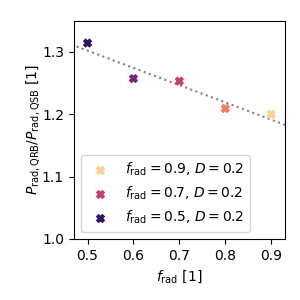

../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R04.50-C.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R04.00-C.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R03.50-C.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R03.00-C.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C.nc


In [137]:
plt.close("all")
fig, ax = plt.subplots(figsize=(3,3))
kW_fac = 1e-3
gv = np.load("./data/volumes.npy")
QSB_index, QRB_index = 35, 13

pqrb_div_pqsb = []
frads, diffs, colors, labels = [], [], [], []
for cpath in cpaths:
    print(cpath)
    ds = xr.open_dataset(cpath)
    dsez = ds.Ez.sum(dim="Ionization", skipna=False).data # dsez.mean(dim=("r", "theta"))
    P = np.nan_to_num(dsez) * gv # W
    torP = P.sum(axis=(0,1))
    
    frad = float(cpath.stem[20:24])/float(cpath.stem[9:13])
    diff = float(2 if cpath.stem[-1]=="C" else cpath.stem[-2:])/10
    
    phi_vals = ds.phi_bounds.data.mean(axis=1) * 180/np.pi
    label = "$f_{\mathrm{rad}} =$" + str(frad) + ", $D=$" + str(diffval)
    label = (None if (0.55<frad<0.65 or 0.75<frad<0.85) else label)
    
    pqrb_div_pqsb.append(torP[QRB_index]/torP[QSB_index])
    colors.append(get_color(frad, diffval))
    frads.append(frad)
    diffs.append(diff)
    ax.scatter([0.7], [100], marker="X", s=30, color=colors[-1], label=label)

ax.scatter(frads, pqrb_div_pqsb, marker="X", s=30, c=colors, zorder=10)
#ax.set_yscale("log"); 
ax.legend(loc=3)
ax.set_xticks([0.5, 0.6, 0.7, 0.8, 0.9])
# ax.grid()
ax.set_ylabel("$P_{\mathrm{rad,QRB}}/P_{\mathrm{rad,QSB}}$ [1]", verticalalignment="baseline")
ax.set_xlabel("$f_{\mathrm{rad}}$ [1]")
ax.set_ylim((1.0, 1.35))
ax.set_xlim((0.47, 0.93))

lin_coeffs = np.polyfit(frads, pqrb_div_pqsb, deg=1)
fitted_pqrb_div_pqsb = lin_coeffs[0]*np.linspace(0,1,2) + lin_coeffs[1]
ax.plot(np.linspace(0,1,2), fitted_pqrb_div_pqsb, c="grey", zorder=9, ls=":")

fig.tight_layout()
fig.savefig(f"{plotfolder}/power-sum-toroidal-change-QSB-QRB-frac.pdf")
fig.savefig(f"{plotfolder}/power-sum-toroidal-change-QSB-QRB-frac.png", dpi=200)


# std is huge!

# std along field line

<IPython.core.display.Javascript object>


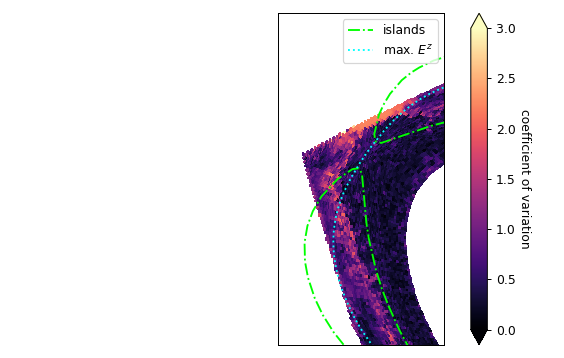

(0.5, 1.1)

In [216]:
cpath = all_paths[6]
ds = xr.open_dataset(cpath)
dsez = ds.Ez.sum(dim="Ionization", skipna=False)
max_ez_r = (dsez.mean(dim=("theta", "phi"))).argmax()

QRB_index, QSB_index = 13, 35
MW_fac = 1e-6
R, Z = crossec_pcolorgrid(ds, phi=QRB_index)
fig, ax = plt.subplots(figsize=(6.3,4))  # figsize=(3,5)



alp_min, alp_max = -3, -2
line_std = dsez.std(dim="phi", skipna=False)
line_mean = dsez.mean(dim="phi", skipna=False)
# alpha_data = ( np.clip(np.nan_to_num(np.log10(MW_fac*line_mean)), 
#                        a_min=alp_min, a_max=alp_max)-alp_min )/(alp_max-alp_min)
alpha_data =1

cb = ax.pcolormesh(R, Z, line_std/line_mean, alpha=alpha_data,
                   cmap=cm.magma, norm=colors.PowerNorm(gamma=1, vmin=0, vmax=3)) # , vmax=2e6)
ax.set_aspect("equal")



for i,file in enumerate(Path("./data/").glob("island*")):
    x, y = np.load(file)
    if i == 0:
        ax.plot(x,y, c="lime", lw=1.5, ls="-.", label="islands")
    else: ax.plot(x,y, c="lime", lw=1.5, ls="-.")
    
ax.plot(ds.R_bounds[max_ez_r,:,QRB_index,0,0,0],ds.z_bounds[max_ez_r,:,QRB_index ,0,0,0], c="cyan",
        ls=":", label="max. $E^z$")
ax.legend(loc=1)
    
ax.set_ylim((0.05, 1.05)); ax.set_xlim((4.9, 6.25))
# ax.set_ylim((0, 1)); ax.set_xlim((5.3, 6.3))
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
cbb = fig.colorbar(cb, extend="both")
cbb.set_label("coefficient of variation",
              rotation=270, verticalalignment='baseline')
fig.tight_layout()
ax.set_xlim((4.9,5.2))
ax.set_ylim((0.5,1.1))

# total std dominated by data scale,
# normalize by deviding by mean (VARIATIONSKOEFFIZIENT)

In [28]:
x = np.array([1,2,3,4,5,6,7])
y = np.array([1,2,4,3,5,6,7])

lin_coeffs = np.polyfit(x, y, deg=1)
new_y = lin_coeffs[0]*x + lin_coeffs[1]

y, new_y

(array([1, 2, 4, 3, 5, 6, 7]),
 array([1.10714286, 2.07142857, 3.03571429, 4.        , 4.96428571,
        5.92857143, 6.89285714]))

<IPython.core.display.Javascript object>


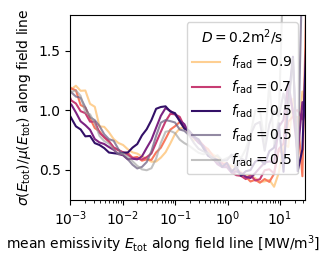

../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R04.50-C.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R04.00-C.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R03.50-C.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R03.00-C.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C-D05.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C-D10.nc


In [6]:
np.warnings.filterwarnings('ignore')  #to ignore warnings (usually due to NaN values)
MW_fac = 1e-6
fig, ax = plt.subplots(figsize=(3.2,2.7))  # figsize=(3,5)

for cpath in all_paths:
    print(cpath)
    ds = xr.open_dataset(cpath)
    dsez = ds.Ez.sum(dim="Ionization", skipna=False)
    max_ez_r = (dsez.mean(dim=("theta", "phi"))).argmax()
    
    # overall
    alp_min, alp_max = -3, -2
    line_std = dsez.std(dim="phi", skipna=False)
    line_mean = dsez.mean(dim="phi", skipna=False)
    coeff_of_var = line_std/line_mean

    N = 100
    bin_edges = np.logspace(np.log10(1e-0), np.log10(1e9), N+1)
    midpts = (bin_edges[1:] + bin_edges[:-1])/2
    bin_map = np.digitize(line_mean, bin_edges)
    
    # noise contribution
    bins_ncovc = np.zeros(N)
    ez_bin_std_along_fieldline = np.zeros(N)
    ez_bin_std_along_fieldline_std = np.zeros(N)
    for i in range(N):
        dsez_full_bin_tor = dsez.data[bin_map == i]  # [(r & tht), phi]
        bin_crossection_mean = dsez_full_bin_tor.mean(axis=0)
        dsez_full_bin_tor_noise = dsez_full_bin_tor - bin_crossection_mean
        # transform into arr with linear values along phi and subtract from orig to get noise
#         dsez_full_bin_tor_noise = np.zeros_like(dsez_full_bin_tor)
#         for ii, v_along_phi in enumerate(dsez_full_bin_tor):
#             lin_coeffs = np.polyfit(ds.phi, v_along_phi, deg=1)
#             fitted_v_along_phi = lin_coeffs[0]*ds.phi + lin_coeffs[1]
#             dsez_full_bin_tor_noise[ii] = v_along_phi - fitted_v_along_phi
        
#         noise_std = dsez_full_bin_tor_noise.std(axis=1)
#         noise_prenoise_mean = dsez_full_bin_tor.mean(axis=1)
#         noise_coeff_var_conbtrib = (noise_std/noise_prenoise_mean).mean()
#         bins_ncovc[i] = noise_coeff_var_conbtrib
        ez_bin_std_along_fieldline[i] = coeff_of_var.data[bin_map == i].mean()
        ez_bin_std_along_fieldline_std[i] = coeff_of_var.data[bin_map == i].std()
        

    frad = float(cpath.stem[20:24])/float(cpath.stem[9:13])
    diffval = float(2 if cpath.stem[-1]=="C" else cpath.stem[-2:])/10
    label = "$f_{\mathrm{rad}} =$" + str(frad)  

#     ax.scatter(MW_fac*midpts, ez_bin_std_along_fieldline, color=get_color(frad, diffval),
#                label=(None if (0.55<frad<0.65 or 0.75<frad<0.85) else label), marker="X", s=20)
    #ax.plot(MW_fac*midpts, ez_bin_std_along_fieldline, c=get_color(frad, diffval), ls="-",
    #       label=(None if (0.55<frad<0.65 or 0.75<frad<0.85) else label))
    ax.errorbar(MW_fac*midpts, ez_bin_std_along_fieldline,
                #yerr=ez_bin_std_along_fieldline_std,
                c=get_color(frad, diffval), fmt="-",
               label=(None if (0.55<frad<0.65 or 0.75<frad<0.85) else label))
    # ax.plot(MW_fac*midpts, bins_ncovc, c=get_color(frad, diffval), ls=":")
    
    
ax.legend(loc=1, title="$D=0.2$m$^2$/s")
#ax.set_yscale("log")
ax.set_xscale("log")
#ax.set_yticks([4e-1, 6e-1, 1e0, 2e0])
#ax.set_yticklabels(["0.4", "0.6", "1", "2"])
ax.set_xticks(np.array([np.linspace(10**(0+i), 10**(1+i), 11) for i in range(-7, 2)]).flatten(), minor=True)
ax.set_xlim((1e-3, 3e1)); ax.set_ylim((0.25, 1.8))

#ax.set_ylabel("mean coefficient of \n variation along voxel field \n lines of given $E_{\mathrm{tot}}$")
ax.set_ylabel("$\sigma (E_{\mathrm{tot}}) / \mu (E_{\mathrm{tot}})$ along field line")
ax.set_xlabel("mean emissivity $E_{\mathrm{tot}}$ along field line [MW/m$^3$]            ")

fig.tight_layout()
fig.tight_layout()
fig.savefig(f"{plotfolder}/coeff-of-var-along-tor-binned-in-ez.pdf")
fig.savefig(f"{plotfolder}/coeff-of-var-along-tor-binned-in-ez.png", dpi=200)


<IPython.core.display.Javascript object>


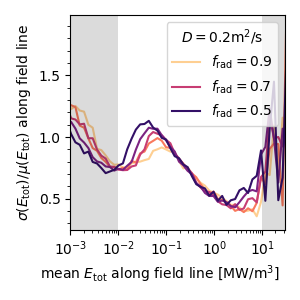

../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R04.50-C.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R04.00-C.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R03.50-C.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R03.00-C.nc
../atomdatpy/NetCDFs-new/N03.00_P05.00_D02_R02.50-C.nc


In [8]:
# test if it comes from inner ones, stop at separatrix (r=47)

np.warnings.filterwarnings('ignore')  #to ignore warnings (usually due to NaN values)
MW_fac = 1e-6
fig, ax = plt.subplots(figsize=(3,3))  # figsize=(3,5)

for cpath in cpaths:
    print(cpath)
    ds = xr.open_dataset(cpath)
    dsez = ds.Ez.sum(dim="Ionization", skipna=False)[47:]
    max_ez_r = (dsez.mean(dim=("theta", "phi"))).argmax()
    
    # overall
    alp_min, alp_max = -3, -2
    line_std = dsez.std(dim="phi", skipna=False)
    line_mean = dsez.mean(dim="phi", skipna=False)
    coeff_of_var = line_std/line_mean

    N = 100
    bin_edges = np.logspace(np.log10(1e-0), np.log10(1e9), N+1)
    midpts = (bin_edges[1:] + bin_edges[:-1])/2
    bin_map = np.digitize(line_mean, bin_edges)
        
        # noise contribution
    bins_ncovc = np.zeros(N)
    ez_bin_std_along_fieldline = np.zeros(N)
    ez_bin_std_along_fieldline_std = np.zeros(N)
    for i in range(N):

        ez_bin_std_along_fieldline[i] = coeff_of_var.data[bin_map == i].mean()
        ez_bin_std_along_fieldline_std[i] = coeff_of_var.data[bin_map == i].std()
        
        
    frad = float(cpath.stem[20:24])/float(cpath.stem[9:13])
    diffval = float(2 if cpath.stem[-1]=="C" else cpath.stem[-2:])/10
    label = "$f_{\mathrm{rad}} =$" + str(frad)  
    
    ax.errorbar(MW_fac*midpts, ez_bin_std_along_fieldline,
                c=get_color(frad, diffval), fmt="-", zorder=2,
                label=(None if (0.55<frad<0.65 or 0.75<frad<0.85) else label))
    
    
ax.legend(loc=1, title="$D=0.2$m$^2$/s")
#ax.set_yscale("log")
ax.set_xscale("log")
#ax.set_yticks([4e-1, 6e-1, 1e0, 2e0])
#ax.set_yticklabels(["0.4", "0.6", "1", "2"])
ax.set_xticks(np.array([np.linspace(10**(0+i), 10**(1+i), 11) for i in range(-7, 2)]).flatten(), minor=True)
ax.set_xlim((1e-3, 3e1)); ax.set_ylim((0.25, 1.99))
ax.set_yticks([0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 1.1, 1.2, 1.3, 1.4, 1.6, 1.7, 1.8, 1.9], minor=True)
ax.set_yticks([0.5,1,1.5], minor=False)

#ax.set_ylabel("mean coefficient of \n variation along voxel field \n lines of given $E_{\mathrm{tot}}$")
ax.set_ylabel("$\sigma (E_{\mathrm{tot}}) / \mu (E_{\mathrm{tot}})$ along field line")
ax.set_xlabel("mean $E_{\mathrm{tot}}$ along field line [MW/m$^3$]         ")

ax.axvspan(1e-5, 1e-2, facecolor=(*(0.0,)*3, 1/7) , zorder=3)
ax.axvspan(1e1, 1e2, facecolor=(*(0.0,)*3, 1/7), zorder=3)

fig.tight_layout()
fig.tight_layout()
fig.savefig(f"{plotfolder}/coeff-of-var-along-tor-binned-in-ez.pdf")
fig.savefig(f"{plotfolder}/coeff-of-var-along-tor-binned-in-ez.png", dpi=200)

<IPython.core.display.Javascript object>


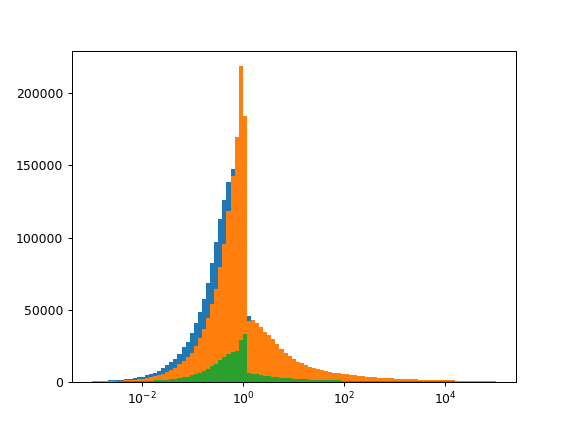

0.8111308307896873
0.8111308307896873
0.9770099572992257


In [17]:
# nearest neighbour differences are in mainly in the 1e4 to 1e6 W/m^3 range
# and of scale as the cells themselves

ds = xr.open_dataset(all_paths[3])
dsez = ds.Ez.sum(dim="Ionization", skipna=False)
max_ez_r = (dsez.mean(dim=("theta", "phi"))).argmax()

plt.close("all")
for i in range(3):
    xxx = np.diff(dsez.data, axis=i)
    nndiffs = np.abs(xxx[np.logical_not(np.isnan(xxx))])
    if i==0: cell_val = dsez.data[1:][np.logical_not(np.isnan(xxx))]
    if i==1: cell_val = dsez.data[:,1:][np.logical_not(np.isnan(xxx))]
    if i==2: cell_val = dsez.data[:,:,1:][np.logical_not(np.isnan(xxx))]
    
    yyy = plt.hist((nndiffs/cell_val), bins=np.logspace(-3,5,100))
    print( yyy[1][yyy[0].argmax()] )

#plt.yscale("log")
plt.xscale("log")

In [19]:
dsez.shape

(139, 512, 36)

In [95]:
np.logical_not(np.isnan(xxx)).shape

(139, 511, 36)

<IPython.core.display.Javascript object>


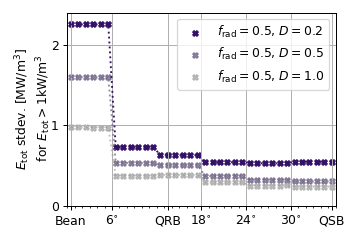

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encounte

In [15]:
plt.close("all")
fig, ax = plt.subplots(figsize=(4,2.7))
MW_fac = 1e-6
lfil, rfil = 1e+3, 1e9  # W/m^3

for cpath in diff_paths:
    ds = xr.open_dataset(cpath)
    dsez = ds.Ez.sum(dim="Ionization", skipna=False)
    dsez_axmean = dsez.mean(dim="phi", skipna=False)
    dsez_axmean_filter = np.logical_and(lfil < dsez_axmean.data, dsez_axmean.data < rfil)
    #dsez_mean = dsez.mean(axis=(0,1))
    dsez_std = dsez.data[dsez_axmean_filter].std(axis=0)
    
    
    frad = float(cpath.stem[20:24])/float(cpath.stem[9:13])
    diffval = float(2 if cpath.stem[-1]=="C" else cpath.stem[-2:])/10
    
    phi_vals = ds.phi_bounds.data.mean(axis=1) * 180/np.pi
    ax.scatter(phi_vals, MW_fac*dsez_std, color=get_color(frad, diffval),
           label="$f_{\mathrm{rad}} =$" + str(frad) + ", $D=$" + str(diffval), marker="X", s=20)
    ax.plot(phi_vals, MW_fac*dsez_std, c=get_color(frad, diffval), ls=":")

#ax.set_yscale("log"); 
ax.legend(loc=1)
ax.set_xlim((0,36))
ax.set_xticks(range(37), minor=True)
ax.set_xticks([0.5, 6, 13.5, 18, 24, 30, 35.5], minor=False)
ax.set_xticklabels(["Bean", "6$^{\circ}$", "QRB", "18$^{\circ}$", "24$^{\circ}$",
                    "30$^{\circ}$", "QSB"])
ax.set_yticks(MW_fac*np.array([0e+6, 1e+6, 2e+6]))
#ax.set_yticklabels(["0.0", "0.05", "0.1", "0.15", "0.2", "0.25", "0.3"])
ax.grid()
ax.set_ylabel("$E_{\mathrm{tot}}$ stdev. [MW/m$^3$]\n for $E_{\mathrm{tot}} > $1kW/m$^3$ ", 
              verticalalignment="baseline")
#ax.set_ylim((MW_fac*6e4, MW_fac*3.5e5))
ax.set_ylim((0,2.4))

fig.tight_layout()
fig.savefig(f"{plotfolder}/emissivity-std-bin-toroidal-change.pdf")
fig.savefig(f"{plotfolder}/emissivity-std-bin-toroidal-change.png", dpi=200)


# to decrease std, focus on large emissivities only (>1kW/m^3)
# higher frads behave equivalently (but hard to say wityh !!6!! data values)

# check how deep targets penetrate toroidally

<xarray.DataArray 'Ez' (phi: 36)>
array([ 50,  50,  50,  50,  50,  50,  50,  50,  50,  50,  50,  50,  51,
        51,  49,  48,  49,  52,  56,  67,  68,  64,  63,  63,  70,  78,
        85,  94, 116, 116, 116, 116, 116, 116, 116, 116])
Dimensions without coordinates: phi

In [7]:
ds = xr.open_dataset(all_paths[0])